# Lotka Volterra UPINN inverse

In [1]:
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import pysindy as ps
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN, ResNet
from LotkaVolterraData import LotkaVolterraData
from utils import SINDy_sklearn, sample_collocation_points

Consider the Lotka-Volterra equations, which describe the dynamics of a predator-prey system:

\begin{align}
\frac{dx}{dt} &= \alpha x - \beta x y, \\
\frac{dy}{dt} &= - \delta y + \gamma x y,
\end{align}

where $x$ is the number of prey, $y$ is the number of predators, and $\alpha$, $\beta$, $\gamma$, and $\delta$ are positive constants.

## Generate Data from System

In [ ]:
# Data
alpha, beta, gamma, delta = 2/3, 4/3, 1.0, 1.0
X0 = torch.tensor([1.0, 1.0]).reshape(-1, 2)

Nd = 8 # Number of data points

time_int = [0, 20]
spacing = (time_int[1] - time_int[0]) / Nd

data_time_points = np.linspace(time_int[0]+spacing, time_int[1], Nd)

data = LotkaVolterraData(X0, alpha, beta, gamma, delta, time_int, time_points=data_time_points)

td = data.td
Xd = data.Xd

In [3]:
# Boundary conditions
tbc = torch.tensor([[0.0]])
Xbc = X0

In [4]:
# Collocation points
N_coll = 1000
Xc = sample_collocation_points(N_coll, 1, lb=[time_int[0]], ub=[time_int[1]], method='grid')

### Known system $N_K$

Assume that $\gamma x y$ is not known, and we want to learn it from data.

In [5]:
class SparseLV(torch.nn.Module):
    
    def __init__(self, params):
        super(SparseLV, self).__init__()
        self.alpha = params['alpha']
        self.beta = params['beta']
        self.delta = params['delta']
        self.gamma = params['gamma']
        self.param_log = dict()

    def forward(self, z, U):

        sp = torch.nn.Softplus()

        if type(self.alpha) == torch.nn.parameter.Parameter: self.param_log.setdefault('alpha', []).append(sp(self.alpha).item())
        if type(self.beta) == torch.nn.parameter.Parameter: self.param_log.setdefault('beta', []).append(sp(self.beta).item()) 
        if type(self.delta) == torch.nn.parameter.Parameter: self.param_log.setdefault('delta', []).append(sp(self.delta).item())
        if type(self.gamma) == torch.nn.parameter.Parameter: self.param_log.setdefault('gamma', []).append(sp(self.gamma).item())

        dUdt = torch.cat([
        torch.autograd.grad(outputs=U[:, i], inputs=z, grad_outputs=torch.ones_like(U[:, i]), create_graph=True)[0]
        for i in range(U.shape[1])
        ], dim=-1)

        return torch.stack([
            dUdt[:, 0] - sp(self.alpha)*U[:, 0] + sp(self.beta)*U[:, 0]*U[:, 1],
            dUdt[:, 1] + sp(self.delta)*U[:, 1] - sp(self.gamma)*U[:, 0]*U[:, 1]
        ], dim=-1)


params = dict(
    alpha=torch.nn.Parameter(torch.tensor(0.0)),
    beta=torch.nn.Parameter(torch.tensor(0.0)),
    delta=torch.nn.Parameter(torch.tensor(0.0)),
    gamma=torch.nn.Parameter(torch.tensor(0.0))
)

N = SparseLV(params)

### Problem specific UPINN functions

In [6]:
class LV_UPINN(UPINN):

    def score(self):
        u_pred = self.u(data.t_full)
        return torch.nn.MSELoss()(u_pred, data.X_full)
    

    def plot(self, save=None):
        
        self.to('cpu')

        with torch.no_grad():
            t_plot = data.t_full
            x_true = data.X_full[:, 0:1]
            y_true = data.X_full[:, 1:2]

            u_pred = self.u(t_plot)
            
            x_pred = u_pred[:, 0]
            y_pred = u_pred[:, 1]

            plt.plot(t_plot, x_pred, 'r', label='Predator')
            plt.plot(t_plot, y_pred, 'b', label='Prey')
            plt.plot(t_plot, x_true, 'r--')
            plt.plot(t_plot, y_true, 'b--')
            plt.xlabel('t')
            plt.legend()

            if save is not None:
                plt.savefig(save+'pdf', format='pdf', bbox_inches='tight')

            plt.show()

### Setup UPINN

In [7]:
# Define model architectures
hidden = [16] * 4
u = FNN(
    dims=[1, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.SiLU(),
)

In [8]:
upinn = LV_UPINN(u, N, boundary_points=(tbc, Xbc), data_points=(td, Xd), collocation_points=Xc)

[Info]: Initializing PINN model (Residual network F unspecified; Setting F to 0.0)


### Train

In [9]:
adamw = torch.optim.AdamW(upinn.parameters(), lr=1e-3, weight_decay=1e-4)
upinn.optimizer = adamw

for i in range(50):
    upinn.train_loop(epochs=1000)
    print(N.param_log['alpha'][-1], N.param_log['beta'][-1], N.param_log['delta'][-1], N.param_log['gamma'][-1])

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 80.97 epoch/s, bc_loss=7.13e-06, data_loss=6.21e-02, pde_loss=3.62e-03, loss=6.58e-02]


0.5221885442733765 0.8935034275054932 0.7197286486625671 0.7595005035400391
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 80.63 epoch/s, bc_loss=4.87e-06, data_loss=5.78e-02, pde_loss=3.50e-03, loss=6.13e-02]


0.5049647688865662 0.8515399694442749 0.8931753635406494 0.9586589336395264
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 78.34 epoch/s, bc_loss=9.78e-07, data_loss=7.89e-03, pde_loss=6.15e-03, loss=1.40e-02]


0.4709797203540802 0.797370195388794 1.2725303173065186 1.3581124544143677
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 75.80 epoch/s, bc_loss=4.32e-07, data_loss=1.77e-03, pde_loss=2.87e-03, loss=4.64e-03]


0.40002021193504333 0.6527528166770935 1.6394575834274292 1.7414817810058594
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 74.94 epoch/s, bc_loss=4.35e-07, data_loss=3.70e-04, pde_loss=1.73e-03, loss=2.10e-03]


0.3498006761074066 0.5927450656890869 1.7471282482147217 1.842609167098999
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 73.96 epoch/s, bc_loss=7.40e-07, data_loss=2.44e-04, pde_loss=1.29e-03, loss=1.54e-03]


0.3278364837169647 0.5735033750534058 1.794695496559143 1.8986872434616089
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 72.78 epoch/s, bc_loss=9.29e-08, data_loss=1.29e-04, pde_loss=8.56e-04, loss=9.86e-04]


0.3208063542842865 0.5766032338142395 1.8357843160629272 1.9557135105133057
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 73.21 epoch/s, bc_loss=3.26e-08, data_loss=4.79e-05, pde_loss=4.33e-04, loss=4.81e-04]


0.32376518845558167 0.5984492301940918 1.859187126159668 2.000922203063965
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 72.75 epoch/s, bc_loss=9.63e-09, data_loss=1.05e-05, pde_loss=1.67e-04, loss=1.78e-04]


0.3326871693134308 0.6292088031768799 1.867194414138794 2.032775402069092
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:16<00:00, 61.03 epoch/s, bc_loss=7.09e-10, data_loss=2.97e-06, pde_loss=8.56e-05, loss=8.86e-05]


0.3394452929496765 0.6502568125724792 1.8710283041000366 2.0483100414276123
[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]:  26%|██▌       | 257/1000 [00:03<00:11, 64.38 epoch/s, bc_loss=3.03e-08, data_loss=2.43e-06, pde_loss=7.64e-05, loss=7.88e-05]


KeyboardInterrupt: 

In [12]:
upinn.load('lv_pinn_forward', 'models')

[Error]: Failed to load N model. Check compatibility with lv_pinn_forward_architecture.txt


Traceback (most recent call last):
  File "c:\Users\jonas\OneDrive - Danmarks Tekniske Universitet\Master Thesis\Master-Thesis\scripts\LotkaVolterra\../../utils\upinn.py", line 158, in load
    try: self.load_state_dict(params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\module.py", line 2215, in load_state_dict
    raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(
RuntimeError: Error(s) in loading state_dict for LV_UPINN:
	Missing key(s) in state_dict: "N.alpha", "N.beta", "N.delta", "N.gamma". 

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\jonas\OneDrive - Danmarks Tekniske Universitet\Master Thesis\Master-Thesis\scripts\LotkaVolterra\../../utils\upinn.py", line 162, in load
    try: getattr(self, key).load_state_dict({k[len(key)+

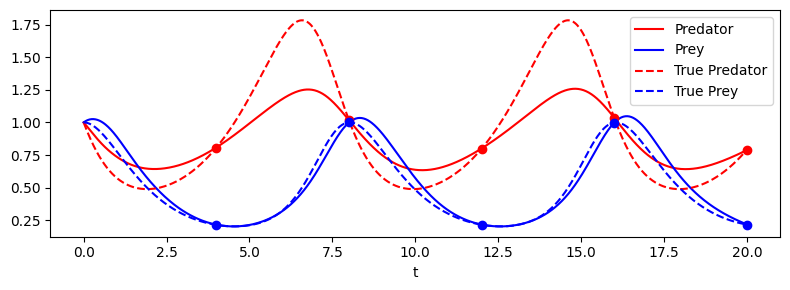

In [15]:
upinn.to('cpu')

plt.figure( figsize=(8, 3) )

u_pred = upinn.u(data.t_full)

plt.plot(data.t_full, u_pred[:, 0].detach().numpy(), 'r', label='Predator')
plt.plot(data.t_full, u_pred[:, 1].detach().numpy(), 'b', label='Prey')
plt.plot(data.t_full, data.X_full[:, 0].detach().numpy(), 'r--', label='True Predator')
plt.plot(data.t_full, data.X_full[:, 1].detach().numpy(), 'b--', label='True Prey')
plt.plot(data.td, data.Xd[:, 0], 'ro')
plt.plot(data.td, data.Xd[:, 1], 'bo')

plt.xlabel('t')
plt.legend()
plt.tight_layout()
plt.savefig('gfx/lv-pinn-inverse.pdf', format='pdf', bbox_inches='tight')
plt.show()

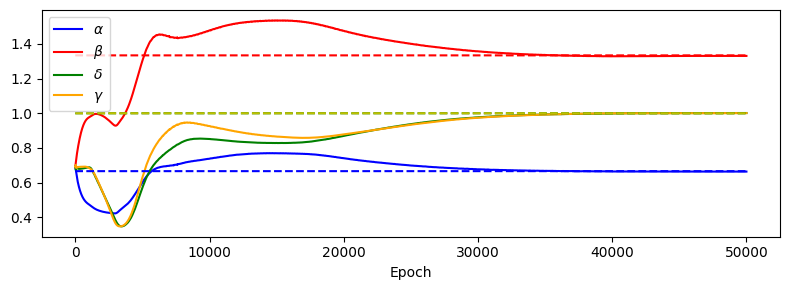

In [31]:
plt.figure( figsize=(8, 3) )

plt.plot(N.param_log['alpha'], label=r'$\alpha$', color='blue')
plt.plot(N.param_log['beta'], label=r'$\beta$', color='red')
plt.plot(N.param_log['delta'], label=r'$\delta$', color='green')
plt.plot(N.param_log['gamma'], label=r'$\gamma$', color='orange')

plt.plot([alpha]*len(N.param_log['alpha']), 'b--')
plt.plot([beta]*len(N.param_log['beta']), 'r--')
plt.plot([delta]*len(N.param_log['delta']), 'g--')
plt.plot([gamma]*len(N.param_log['gamma']), 'y--')

plt.legend()
plt.xlabel('Epoch')

plt.tight_layout()
plt.savefig('gfx/lv-pinn-inverse-params.pdf', format='pdf', bbox_inches='tight')
plt.show()